In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fmin_cg
import scipy.io as si
plt.rcParams['axes.formatter.limits'] = [-3,3]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 1. Neural Networks

## 1.1 Visualizing the data

In [159]:
a = si.loadmat('ex4_octave/ex4data1.mat')
X = a['X']
yy = a['y'].flatten()

# replace 10 -> 0 because Matlab is stupid
#yy[np.flatnonzero(yy==10)] = 0

# re-cast y
y = np.zeros((len(yy), 10))
for ii in range(y.shape[0]):
    y[ii, yy[ii]-1] = 1

In [119]:
print y[:,-999], yy[-999]

[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.] 8


In [323]:
def displayData(X, nrows=10, ncols=10):
    
    # set up array
    fig, axarr = plt.subplots(nrows=nrows, ncols=ncols,
                              figsize=(nrows,ncols))
    
    # loop over randomly drawn numbers
    for ii in range(nrows):
        for jj in range(ncols):
            ind = np.random.randint(X.shape[0])
            tmp = X[ind,:].reshape(20,20, order='F')
            axarr[ii,jj].imshow(tmp, cmap='gray_r')
            plt.setp(axarr[ii,jj].get_xticklabels(), visible=False)
            plt.setp(axarr[ii,jj].get_yticklabels(), visible=False)
    
    fig.subplots_adjust(hspace=0, wspace=0)

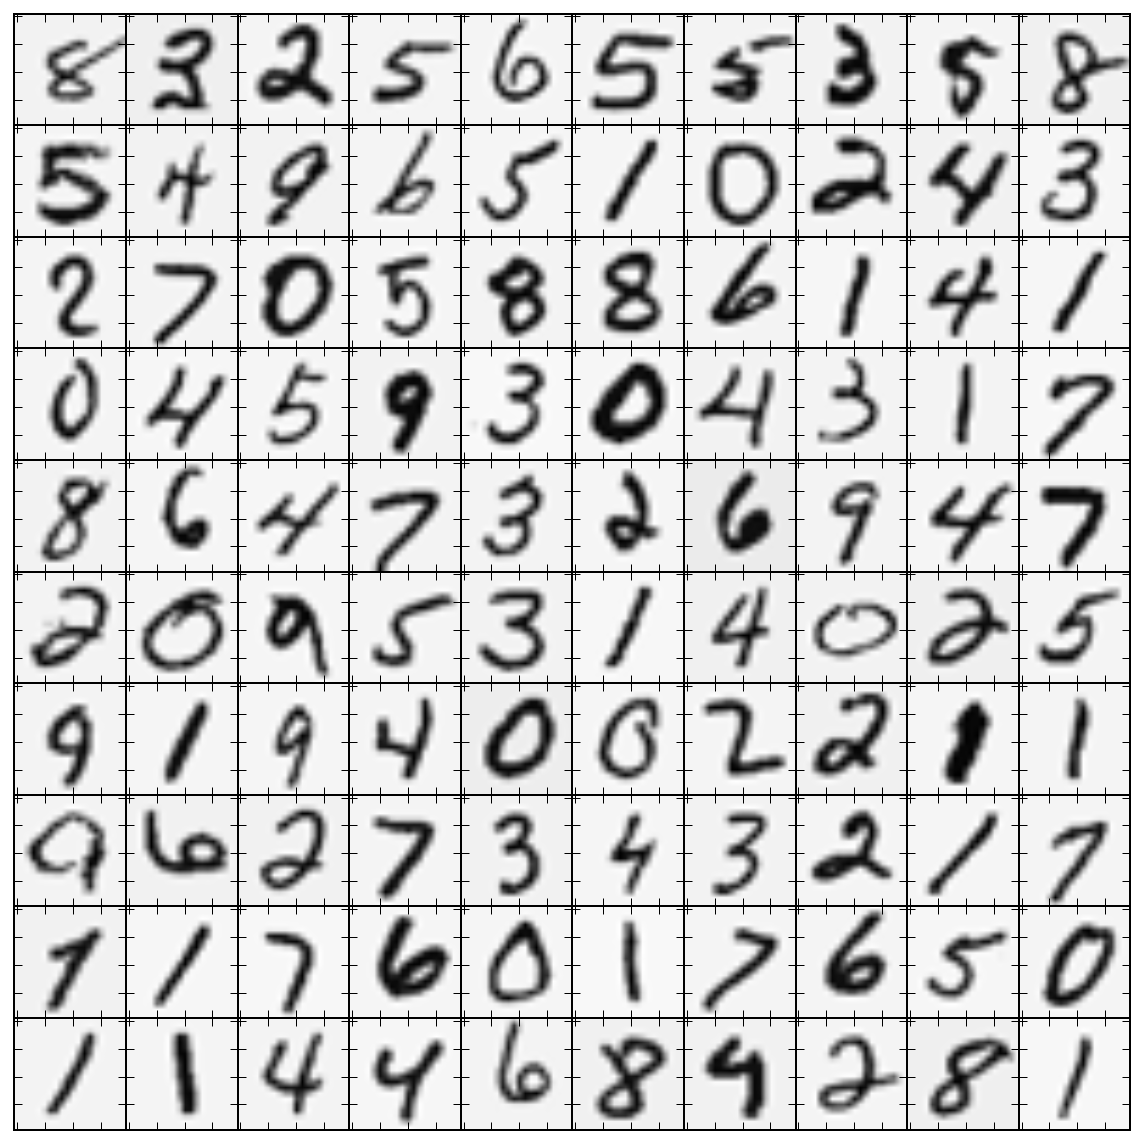

In [320]:
displayData(X)

## 1.2 Model representation

In [122]:
# read in pre-computed weights
a = si.loadmat('ex4_octave/ex4weights.mat')
Theta1 = a['Theta1']
Theta2 = a['Theta2']

# unroll parameters
nn_params = np.concatenate((np.reshape(Theta1, Theta1.size, order='F'),
                            np.reshape(Theta2, Theta2.size, order='F')))

## 1.3 Feedforward and cost function

In [284]:
def sigmoid(z):
    
    return 1 / (1 + np.exp(-z))

def sigmoidGradient(z):
    
    return sigmoid(z) * (1-sigmoid(z))

def randInitializeWeights(L_in, L_out):
    
    epsilon_int = 0.12
    W = np.random.rand(L_out, 1+L_in) * 2 * epsilon_int - epsilon_int
    
    return W

def compute_cost(Theta1, Theta2, X, y, lam):
    
    # tolerance for sigmoid function.
    # i.e., 1-htheta cannot be less than 1e-15
    # this fixes loss of precision errors
    eps = 1e-15
    
    # sizes
    m, n = X.shape
    
    # add ones to X data matrix
    X = np.hstack((np.ones((m, 1)), X))
            
    # hidden layer
    z2 = np.dot(X, Theta1.T)
    a2 = sigmoid(z2)
    
    #add bias unit to a2
    a2 = np.hstack((np.ones((a2.shape[0],1)), a2))

    # output layer
    z3 = np.dot(a2, Theta2.T)
    htheta = sigmoid(z3)
    
    # back prop
    delta3 = htheta - y
    delta2 = np.dot(delta3, Theta2)[:,1:] * sigmoidGradient(z2)
    #print np.dot(htheta, Theta2)[:,1:].shape, sigmoidGradient(z2).shape
        
    Delta1 = np.dot(delta2.T, X)
    Delta2 = np.dot(delta3.T, a2)
    
    Theta1_grad = 1 / m * Delta1
    Theta2_grad = 1 / m * Delta2
    
    # regularization
    Theta1_grad[:,1:] += lam / m * Theta1[:,1:]
    Theta2_grad[:,1:] += lam / m * Theta2[:,1:]
                
    # pack gradient
    grad = np.concatenate((np.reshape(Theta1_grad, Theta1_grad.size, order='F'),
                            np.reshape(Theta2_grad, Theta2_grad.size, order='F')))
    
            
    # compute J in three terms
    term1 = np.sum(np.log(htheta)* y)
    term2 = np.sum(np.log(1-htheta+eps)* (1-y))
    term3 =  lam / 2 * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2)) 
    
    # cost function
    J = - 1 / m * np.sum((term1 + term2 - term3)) 
    
    return J, grad
    
    
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                   num_labels, X, y, lam):
    
    # Reshape nn_params back into the parameters for Theta
    Theta1 = np.reshape(nn_params[:hidden_layer_size*(input_layer_size+1)],
                        (hidden_layer_size, input_layer_size+1), order='F')
    Theta2 = np.reshape(nn_params[hidden_layer_size*(input_layer_size+1):], 
                        (num_labels, (hidden_layer_size+1)), order='F')
    
    # compute cost function
    J, grad = compute_cost(Theta1, Theta2, X, y, lam)
    
    return J, grad

In [285]:
# parameters
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10

In [286]:
# compute cost function for trained parameters
J, grad = nnCostFunction(nn_params, input_layer_size,
                         hidden_layer_size, num_labels, 
                         X, y, 1)
print J , grad.shape

0.383769859091 (10285,)


In [287]:
# test sigmoid gradient
sg = sigmoidGradient(0)
print sg

0.25


## 2.4 Gradient Checking

In [278]:
def computeNumericalGradient(J, theta):
    
    numgrad = np.zeros(len(theta))
    perturb = np.zeros(len(theta))
    e = 1e-4
    for p in range(len(theta)):
        
        # Set perturbarion vactor
        perturb[p] = e
        loss1 = J(theta - perturb)
        loss2 = J(theta + perturb)
        
        # compute numerical gradient
        numgrad[p] = (loss2 - loss1) / (2*e)
        perturb[p] = 0
        
    return numgrad

def checkNNGradients(lam=0):
    
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    
    # generate some random test data
    Theta1 = randInitializeWeights(hidden_layer_size, input_layer_size)
    Theta2 = randInitializeWeights(num_labels, hidden_layer_size)
    
    X = randInitializeWeights(input_layer_size-1, m)
    yy = 1 + np.mod(np.arange(m), num_labels)
    
    # re-cast y
    y = np.zeros((len(yy), num_labels))
    for ii in range(y.shape[0]):
        y[ii, yy[ii]-1] = 1
        
    
    # unroll parameters
    nn_params = np.concatenate((np.reshape(Theta1, Theta1.size, order='F'),
                            np.reshape(Theta2, Theta2.size, order='F')))
    
    # cost function
    costFunc = lambda p: nnCostFunction(p, input_layer_size,
                         hidden_layer_size, num_labels, 
                         X, y, lam)[0]
    
    cost, grad = nnCostFunction(nn_params, input_layer_size,
                         hidden_layer_size, num_labels, 
                         X, y, lam)
    numgrad = computeNumericalGradient(costFunc, nn_params)
    
    ct = 0
    for g, ng in zip(grad, numgrad):
        print ct, g, ng, np.abs(g-ng) / ng
        ct += 1
    
    

In [288]:
checkNNGradients()

(3, 6) (5, 4)
0 -0.00818592554077 -0.0081859255352 -6.80708420641e-10
1 0.00299031885604 0.00299031885032 1.9139441739e-09
2 -0.00529465698674 -0.00529465698174 -9.44478553291e-10
3 -0.000455523007023 -0.000455523005982 -2.28483579859e-09
4 -0.00323916061497 -0.00323916061307 -5.87072892383e-10
5 0.0301517941142 0.0301517941148 2.00790205323e-11
6 -0.0135197045166 -0.0135197045181 -1.14028098738e-10
7 0.0697000228832 0.0697000228866 4.88607479482e-11
8 0.0370903335413 0.0370903335378 9.32330885012e-11
9 0.00490242669935 0.00490242670015 1.635485654e-10
10 0.016567406344 0.0165674063402 2.35148475808e-10
11 -0.0445840893719 -0.0445840893737 -3.93907193638e-11
12 0.0160480482145 0.0160480482148 1.47509424081e-11
13 0.0166911729939 0.0166911729926 7.41530217515e-11
14 0.019618426986 0.0196184269874 6.86844646261e-11
15 -0.0490079350618 -0.0490079350612 -1.23326656175e-11
16 -0.00589452799403 -0.0058945279946 -9.66403693264e-11
17 0.0598649336206 0.0598649336236 5.01724370752e-11
18 0.0467

## 2.5 Regularized Neural Networks

In [290]:
checkNNGradients(3)

(3, 6) (5, 4)
0 0.00634291465434 0.00634291465129 4.80919241106e-10
1 0.00370017037878 0.00370017037454 1.14555921983e-09
2 -0.00471348070623 -0.00471348070352 -5.74969797771e-10
3 -0.00421836596356 -0.00421836596098 -6.10996341776e-10
4 0.00585417920983 0.00585417920806 3.01365048351e-10
5 -0.0529707369063 -0.0529707369057 -1.08488627457e-11
6 -0.00733379987174 -0.00733379986961 -2.89962305487e-10
7 -0.051832955725 -0.0518329557253 -5.49604561883e-12
8 -0.0388020272323 -0.0388020272357 -8.88659559252e-11
9 -0.0353384266869 -0.0353384266871 -5.81094421691e-12
10 0.0457254558064 0.0457254558062 4.23416266264e-12
11 -0.046455276712 -0.0464552767121 -1.21689445497e-12
12 0.0279387496946 0.0279387496982 1.28325485589e-10
13 -0.0113224168196 -0.0113224168197 -3.9439681854e-12
14 0.04877284529 0.0487728452914 2.7989697173e-11
15 -0.0708598634149 -0.0708598634103 -6.52676399742e-11
16 0.0481016170587 0.0481016170584 6.01528502769e-12
17 -0.0505931671546 -0.0505931671557 -2.19734800255e-11
18 

## 2.6 Learning parameters

In [304]:
def predict(Theta1, Theta2, X):
    
    # sizes
    m, n = X.shape
    num_labels = Theta2.shape[0]
    
    # add ones to X data matrix
    X = np.hstack((np.ones((m, 1)), X))
        
    # hidden layer
    z2 = np.dot(X, Theta1.T)
    a2 = sigmoid(z2)

    #add bias unit to a2
    a2 = np.hstack((np.ones((a2.shape[0],1)), a2))

    # output layer
    z3 = np.dot(a2, Theta2.T)
    a3 = sigmoid(z3)

    p = np.argmax(a3, axis=1)
    
    return p

In [317]:
lam = 1
maxiter = 400

# function prototypes
cost = lambda x: nnCostFunction(x, input_layer_size,
                         hidden_layer_size, num_labels, 
                         X, y, lam)[0]

grad = lambda x: nnCostFunction(x, input_layer_size,
                         hidden_layer_size, num_labels, 
                         X, y, lam)[1]

# initialize parameters
init_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
init_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

init_nn_params = np.concatenate((np.reshape(init_Theta1, init_Theta1.size, order='F'),
                            np.reshape(init_Theta2, init_Theta2.size, order='F')))

# run minimization
nn_params = fmin_cg(cost, init_nn_params, fprime=grad, maxiter=maxiter, disp=False)

# Reshape nn_params back into the parameters for Theta
Theta1 = np.reshape(nn_params[:hidden_layer_size*(input_layer_size+1)],
                    (hidden_layer_size, input_layer_size+1), order='F')
Theta2 = np.reshape(nn_params[hidden_layer_size*(input_layer_size+1):], 
                    (num_labels, (hidden_layer_size+1)), order='F')

In [318]:
p = predict(Theta1, Theta2, X)
print 'Training set Accuracy: %2.2f percent' % (np.mean(p+1==yy)*100)

Training set Accuracy: 99.48 percent


# 3 Visualizing the hidden layer

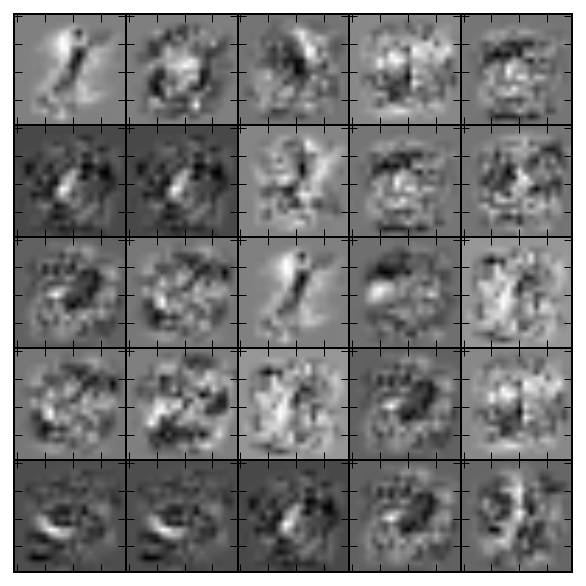

In [326]:
displayData(Theta1[:,1:], nrows=5, ncols=5)